In [1]:
import pandas as pd

data_resampled = pd.read_csv("../ECG_DATASET/dataset_ekg_resampled_no_outliers.csv")
data_resampled.head()

,0,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,target
0,-0.064515,-0.059515,-0.029515,-0.019515,-0.014515,-0.014515,-0.019515,-0.009515,0.020485,0.030485,...,0.125485,0.130485,0.120485,0.110485,0.110485,0.120485,0.135485,0.130485,0.115485,NSR
1,0.245485,0.250485,0.240485,0.230485,0.240485,0.240485,0.250485,0.235485,0.215485,0.220485,...,0.390485,0.375485,0.375485,0.385485,0.370485,0.355485,0.340485,0.335485,0.315485,NSR
2,0.130485,0.125485,0.110485,0.100485,0.105485,0.115485,0.120485,0.095485,0.090485,0.085485,...,-0.139515,-0.144515,-0.164515,-0.159515,-0.169515,-0.189515,-0.204515,-0.204515,-0.204515,NSR
3,-0.499515,-0.409515,-0.394515,-0.419515,-0.469515,-0.504515,-0.559515,-0.589515,-0.614515,-0.639515,...,-0.694515,-0.709515,-0.699515,-0.689515,-0.669515,-0.684515,-0.694515,-0.694515,-0.674515,NSR
4,0.245485,0.265485,0.255485,0.250485,0.230485,0.235485,0.245485,0.280485,0.270485,0.275485,...,0.115485,0.110485,0.120485,0.130485,0.140485,0.135485,0.120485,0.110485,0.120485,NSR


In [2]:
data_resampled.target.value_counts()

target
NSR          269
Bigeminy     267
Trigeminy    232
Name: count, dtype: int64

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Hiperparámetros
LATENT_DIM = 128
NUM_CLASSES = 3
SIGNAL_LENGTH = 3600
BATCH_SIZE = 16
EPOCHS = 300
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.0002
BETA1 = 0.5
LAMBDA_GP = 10  # Gradient penalty

# Mapeo de clases
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(data_resampled['target'].unique()))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
print(f"Mapeo de clases: {class_to_idx}")

# Normalizar datos entre -1 y 1
X = data_resampled.drop(columns=['target']).values.astype(np.float32)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = 2 * (X - X_min) / (X_max - X_min + 1e-7) - 1

# Dataset personalizado
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = torch.FloatTensor(self.signals[idx])
        label = torch.LongTensor([self.labels[idx]])
        return signal, label

# Crear dataset y dataloader
labels = data_resampled['target'].map(class_to_idx).values
dataset = ECGDataset(X_normalized, labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dataset creado con {len(dataset)} muestras")

# Spectral Normalization
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        self._make_spectral_norm()
    
    def _make_spectral_norm(self):
        weight = getattr(self.module, self.name)
        h, w = weight.shape[0], weight.view(weight.shape[0], -1).shape[1]
        u = nn.Parameter(torch.randn(1, h).normal_(0, 1), requires_grad=False)
        setattr(self.module, self.name + '_u', u)
    
    def forward(self, *args, **kwargs):
        return self.module(*args, **kwargs)

# Generador mejorado con Residual connections
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, signal_length):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.signal_length = signal_length
        
        # Embedding para la clase
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        
        # Capas principales
        self.fc1 = nn.Linear(latent_dim + latent_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc3 = nn.Linear(1024, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        
        self.fc4 = nn.Linear(2048, 4096)
        self.bn4 = nn.BatchNorm1d(4096)
        
        self.fc5 = nn.Linear(4096, signal_length)
        
        self.relu = nn.LeakyReLU(0.2)
    
    def forward(self, z, labels):
        if labels.dim() > 1:
            labels = labels.squeeze()
        label_emb = self.label_emb(labels)
        if label_emb.dim() == 1:
            label_emb = label_emb.unsqueeze(0)
        if z.dim() == 1:
            z = z.unsqueeze(0)
        
        x = torch.cat([z, label_emb], dim=1)
        
        # Forward pass con residual connections parciales
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        
        # Tanh para mantener en [-1, 1]
        x = torch.tanh(x)
        return x

# Discriminador mejorado - WGAN-GP style
class Discriminator(nn.Module):
    def __init__(self, num_classes, signal_length):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.signal_length = signal_length
        
        # Embedding para la clase
        self.label_emb = nn.Embedding(num_classes, signal_length)
        
        # Capas principales
        self.fc1 = nn.Linear(signal_length + signal_length, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 1)
        
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, signal, labels):
        if labels.dim() > 1:
            labels = labels.squeeze()
        label_emb = self.label_emb(labels)
        if label_emb.dim() == 1:
            label_emb = label_emb.unsqueeze(0)
        if signal.dim() == 1:
            signal = signal.unsqueeze(0)
        
        x = torch.cat([signal, label_emb], dim=1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.fc5(x)
        
        return x

# Función de gradient penalty para WGAN-GP
def compute_gradient_penalty(discriminator, real_signals, fake_signals, labels, device):
    batch_size = real_signals.size(0)
    alpha = torch.rand(batch_size, 1).to(device)
    
    interpolates = (alpha * real_signals + (1 - alpha) * fake_signals).requires_grad_(True)
    
    d_interpolates = discriminator(interpolates, labels)
    
    fake = torch.ones(batch_size, 1).to(device).requires_grad_(False)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

# Inicializar modelos
generator = Generator(LATENT_DIM, NUM_CLASSES, SIGNAL_LENGTH).to(device)
discriminator = Discriminator(NUM_CLASSES, SIGNAL_LENGTH).to(device)

# Inicializar pesos
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights)

# Optimizadores
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, 0.999))

print("Modelos inicializados correctamente")
print(f"Generator total params: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator total params: {sum(p.numel() for p in discriminator.parameters()):,}")

Usando dispositivo: cuda
Mapeo de clases: {'Bigeminy': 0, 'NSR': 1, 'Trigeminy': 2}
Dataset creado con 768 muestras
Modelos inicializados correctamente
Generator total params: 25,913,744
Discriminator total params: 40,520,241
Modelos inicializados correctamente
Generator total params: 25,913,744
Discriminator total params: 40,520,241


Iniciando entrenamiento WGAN-GP...


Epoch 1/300:   0%|          | 0/48 [00:00<?, ?it/s]/home/hinton2/.local/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/hinton2/.local/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 10/300 - G_loss: 213.3732, D_loss: 48.1442


Epoch 20/300 - G_loss: -2863.8084, D_loss: 50.6912


Epoch 30/300 - G_loss: 3050.8816, D_loss: -400.0206


Epoch 40/300 - G_loss: -13399.9844, D_loss: 921.5418


Epoch 50/300 - G_loss: 17285.2388, D_loss: 1259.2377


Epoch 60/300 - G_loss: -11018.5302, D_loss: 1761.2234


Epoch 70/300 - G_loss: 4143.2165, D_loss: -3484.3174


Epoch 80/300 - G_loss: -8080.6433, D_loss: -1146.8673


Epoch 90/300 - G_loss: -27237.5741, D_loss: 1169.4806


Epoch 100/300 - G_loss: -33918.0024, D_loss: 1582.5345


Epoch 110/300 - G_loss: -2221.2390, D_loss: 799.7345


Epoch 120/300 - G_loss: -46046.1181, D_loss: -2028.9898


Epoch 130/300 - G_loss: -30193.0710, D_loss: 610.1676


Epoch 140/300 - G_loss: -78562.4188, D_loss: -877.6192


Epoch 150/300 - G_loss: -21619.9876, D_loss: 972.5120


Epoch 160/300 - G_loss: 3804.7917, D_loss: -14902.8727


Epoch 170/300 - G_loss: 26543.1694, D_loss: 5231.8368


Epoch 180/300 - G_loss: -38718.7591, D_loss: -404.0609


Epoch 190/300 - G_loss: 5894.5363, D_loss: 8642.7894


Epoch 200/300 - G_loss: 27094.3482, D_loss: 3602.7489


Epoch 210/300 - G_loss: 31783.6027, D_loss: 3095.0406


Epoch 220/300 - G_loss: -3869.3376, D_loss: -1578.1954


Epoch 230/300 - G_loss: 14051.3148, D_loss: -12961.0461


Epoch 240/300 - G_loss: -2076.2667, D_loss: 3753.9811


Epoch 250/300 - G_loss: 5955.8690, D_loss: -1853.1230


Epoch 260/300 - G_loss: 10657.1303, D_loss: 1622.0199


Epoch 270/300 - G_loss: -12518.9057, D_loss: -15163.7399


Epoch 280/300 - G_loss: -55940.1181, D_loss: 2635.7346


Epoch 290/300 - G_loss: -82734.3965, D_loss: 15115.5033


Epoch 300/300 - G_loss: -66688.4966, D_loss: 15636.9746


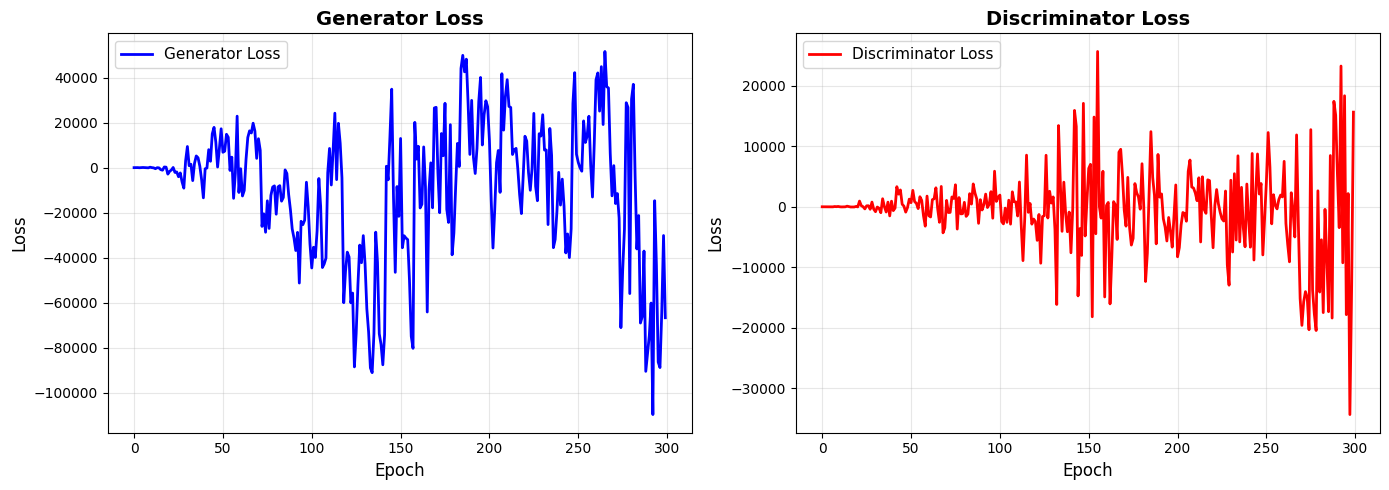

Entrenamiento completado


In [4]:
# Entrenamiento WGAN-GP
def train_cgan(epochs):
    g_losses = []
    d_losses = []
    
    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0
        
        for batch_idx, (signals, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)):
            signals = signals.to(device)
            labels = labels.to(device)
            
            batch_size = signals.size(0)
            
            # ============= Entrenar Discriminador (5 pasos) =============
            for _ in range(5):
                optimizer_d.zero_grad()
                
                # Señales reales
                real_output = discriminator(signals, labels)
                
                # Señales falsas
                z = torch.randn(batch_size, LATENT_DIM).to(device)
                fake_signals = generator(z, labels)
                fake_output = discriminator(fake_signals.detach(), labels)
                
                # Wasserstein loss
                loss_d = -torch.mean(real_output) + torch.mean(fake_output)
                
                # Gradient penalty
                gp = compute_gradient_penalty(discriminator, signals, fake_signals.detach(), labels, device)
                loss_d = loss_d + LAMBDA_GP * gp
                
                loss_d.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
                optimizer_d.step()
            
            # ============= Entrenar Generador =============
            optimizer_g.zero_grad()
            
            z = torch.randn(batch_size, LATENT_DIM).to(device)
            fake_signals = generator(z, labels)
            fake_output = discriminator(fake_signals, labels)
            
            # Wasserstein loss para el generador
            loss_g = -torch.mean(fake_output)
            
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
            optimizer_g.step()
            
            epoch_g_loss += loss_g.item()
            epoch_d_loss += loss_d.item()
            num_batches += 1
        
        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}")
    
    return g_losses, d_losses

# Entrenar el modelo
print("Iniciando entrenamiento WGAN-GP...")
g_losses, d_losses = train_cgan(EPOCHS)

# Graficar pérdidas
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(g_losses, label='Generator Loss', linewidth=2, color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.title('Generator Loss', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
plt.plot(d_losses, label='Discriminator Loss', linewidth=2, color='red')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.title('Discriminator Loss', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Entrenamiento completado")

Generando señales sintéticas...
Se generaron 60 señales sintéticas


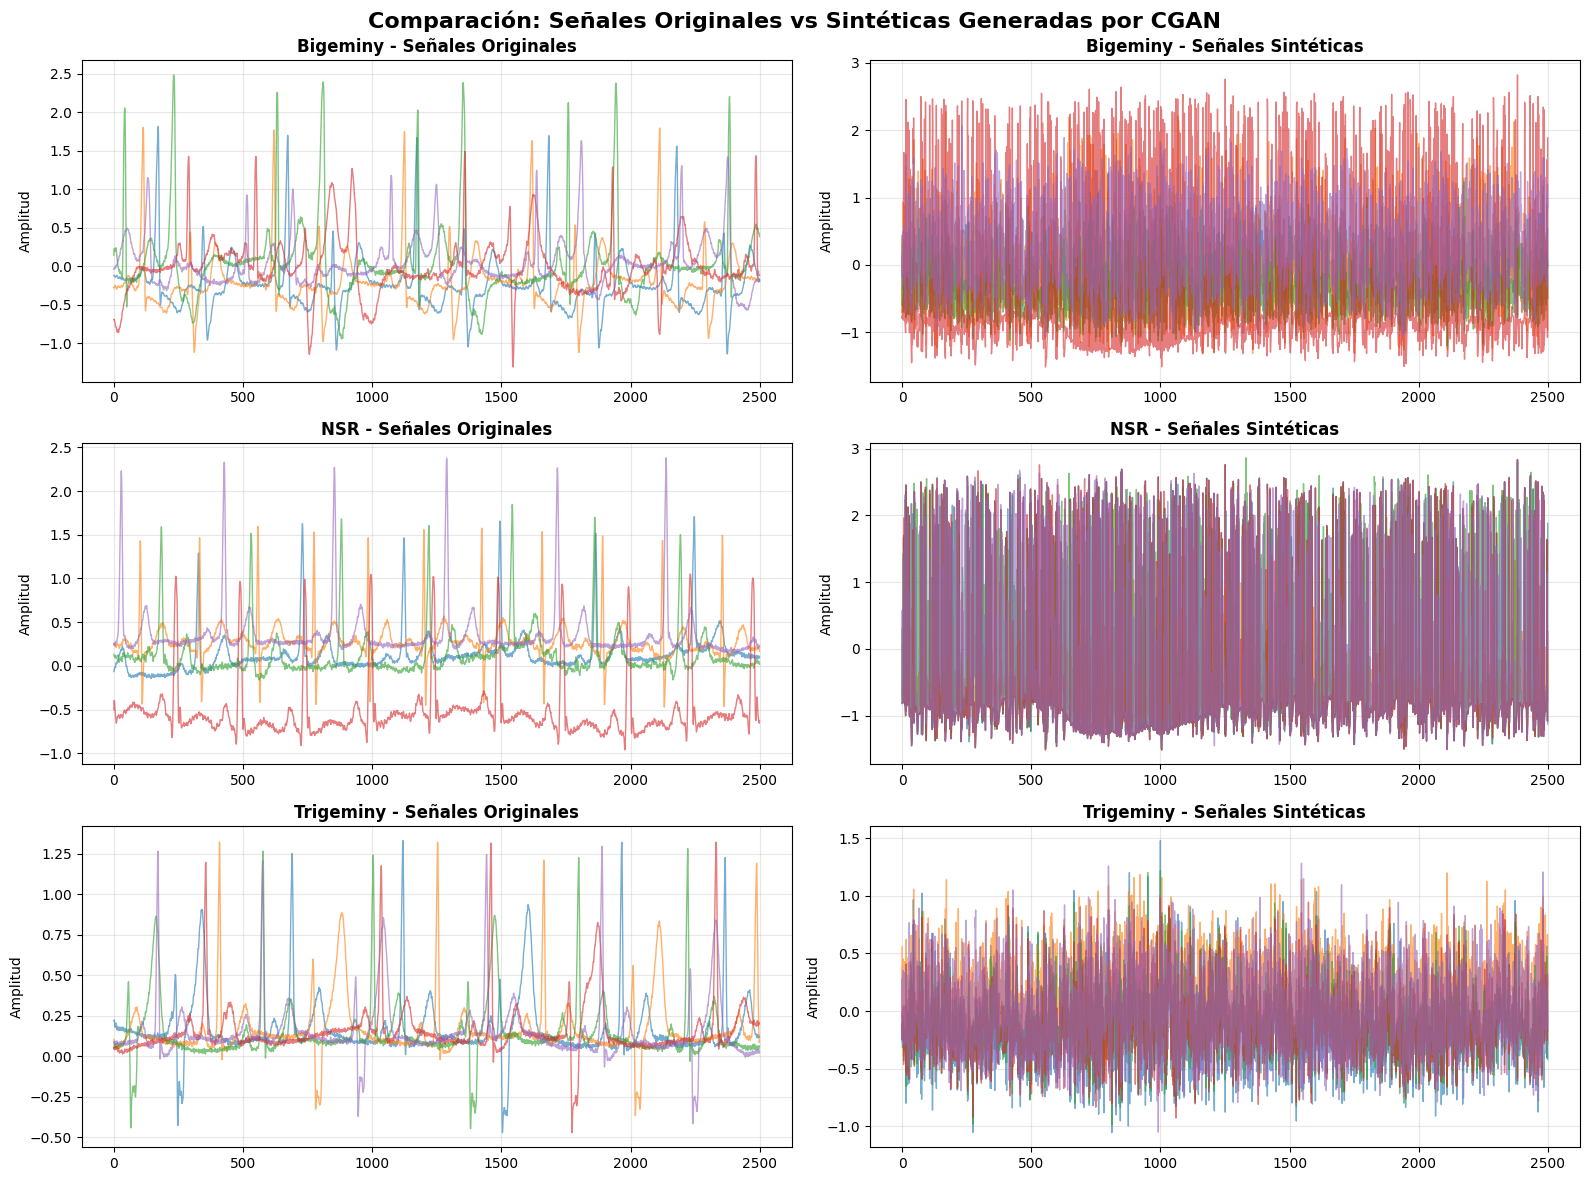

Visualización completada


In [5]:
# Generar señales sintéticas
def generate_synthetic_signals(num_samples_per_class=20):
    """Genera señales sintéticas para cada clase y las desnormaliza"""
    generator.eval()
    synthetic_data = []
    
    with torch.no_grad():
        for class_idx, class_name in idx_to_class.items():
            for _ in range(num_samples_per_class):
                z = torch.randn(1, LATENT_DIM).to(device)
                label = torch.LongTensor([class_idx]).to(device)
                
                fake_signal_norm = generator(z, label)
                fake_signal_norm = fake_signal_norm.cpu().numpy()[0]
                
                # Desnormalizar: convertir de [-1, 1] a rango original
                fake_signal = (fake_signal_norm + 1) / 2 * (X_max - X_min) + X_min
                
                synthetic_data.append({
                    'signal': fake_signal,
                    'class': class_name,
                    'class_idx': class_idx
                })
    
    return synthetic_data

# Generar señales
print("Generando señales sintéticas...")
synthetic_signals = generate_synthetic_signals(num_samples_per_class=20)
print(f"Se generaron {len(synthetic_signals)} señales sintéticas")

# Visualizar comparación: originales vs sintéticas
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Comparación: Señales Originales vs Sintéticas Generadas por CGAN', 
             fontsize=16, fontweight='bold')

max_values_plot = 2500

for class_idx, class_name in idx_to_class.items():
    # Original
    orig_signals = X[labels == class_idx]
    ax_orig = axes[class_idx, 0]
    for i in range(min(5, len(orig_signals))):
        ax_orig.plot(orig_signals[i][:max_values_plot], alpha=0.6, linewidth=1)
    ax_orig.set_title(f'{class_name} - Señales Originales', fontsize=12, fontweight='bold')
    ax_orig.grid(True, alpha=0.3)
    ax_orig.set_ylabel('Amplitud')
    
    # Sintéticas
    synth_signals = np.array([s['signal'] for s in synthetic_signals if s['class'] == class_name])
    ax_synth = axes[class_idx, 1]
    for i in range(min(5, len(synth_signals))):
        ax_synth.plot(synth_signals[i][:max_values_plot], alpha=0.6, linewidth=1)
    ax_synth.set_title(f'{class_name} - Señales Sintéticas', fontsize=12, fontweight='bold')
    ax_synth.grid(True, alpha=0.3)
    ax_synth.set_ylabel('Amplitud')

plt.tight_layout()
plt.show()

print("Visualización completada")

(0.0, 1500.0)

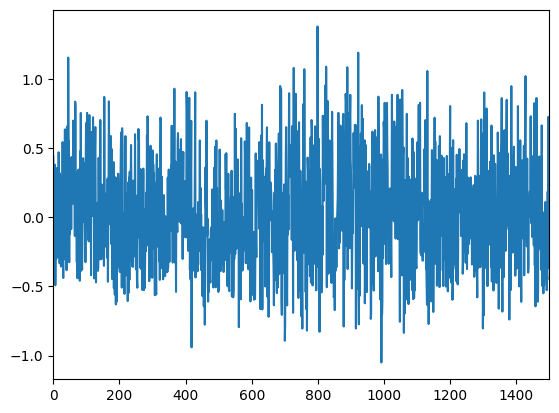

In [10]:
sin1 = synthetic_signals[0]["signal"]
plt.plot(sin1)
plt.xlim(0,1500)

In [ ]:
# Guardar modelos
print("Guardando modelos...")
#torch.save(generator.state_dict(), 'generator_cgan_ecg.pth')
#torch.save(discriminator.state_dict(), 'discriminator_cgan_ecg.pth')
print("Modelos guardados correctamente")

# Crear DataFrame con señales sintéticas
synthetic_df_list = []
for sample in synthetic_signals:
    row = {'target': sample['class']}
    signal_values = sample['signal']
    # Agregar cada valor de la señal como una columna
    for i, val in enumerate(signal_values):
        row[i] = val
    synthetic_df_list.append(row)

synthetic_df = pd.DataFrame(synthetic_df_list)
print(f"\nDataFrame de señales sintéticas creado")
print(f"Shape: {synthetic_df.shape}")
print(f"Distribución de clases:\n{synthetic_df['target'].value_counts()}")

# Guardar DataFrame
#synthetic_df.to_csv('../ECG_DATASET/synthetic_signals_cgan.csv', index=False)
#print("\nSeñales sintéticas guardadas en: ../ECG_DATASET/synthetic_signals_cgan.csv")

# Mostrar ejemplo
print("\nEjemplo de datos sintéticos:")
synthetic_df.head()

Guardando modelos...
Modelos guardados correctamente

DataFrame de señales sintéticas creado
Shape: (60, 3601)
Distribución de clases:
target
Bigeminy     20
NSR          20
Trigeminy    20
Name: count, dtype: int64

Ejemplo de datos sintéticos:
Modelos guardados correctamente

DataFrame de señales sintéticas creado
Shape: (60, 3601)
Distribución de clases:
target
Bigeminy     20
NSR          20
Trigeminy    20
Name: count, dtype: int64

Ejemplo de datos sintéticos:


,target,0,1,2,3,4,5,6,7,8,...,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599
0,Bigeminy,0.438900,-0.347279,0.320031,0.121617,0.207675,0.380251,-0.491343,-0.059083,-0.209926,...,-0.317260,0.518745,0.618230,-0.172463,0.141667,0.239997,0.319552,0.391902,-0.472026,0.217417
1,Bigeminy,0.399201,-0.706592,-0.141390,0.932177,-0.637493,-0.480086,-0.685656,0.888867,-0.706774,...,-0.978432,-0.180820,0.009005,-0.464684,-0.356238,-0.383307,0.169110,0.533628,-0.426377,0.288827
2,Bigeminy,-0.351895,-0.612524,-0.349925,-0.214433,-0.299227,-0.134836,-0.688801,-0.599719,-0.599137,...,-0.898576,-0.226303,-0.359838,-0.503029,-0.557774,-0.566678,-0.196675,-0.248123,-0.694518,-0.381908
3,Bigeminy,-0.764984,-0.794487,-0.641938,-0.793708,-0.798859,-0.503355,-0.817197,1.671536,1.578490,...,2.405760,-1.014280,-0.902699,-0.799493,-1.064514,2.150808,-0.874475,-0.754508,-0.803144,-0.829431
4,Bigeminy,0.135990,-0.180338,0.193805,0.005432,0.494676,-0.116730,-0.308032,-0.243934,0.580126,...,0.424281,0.807053,1.049618,0.665294,-0.250757,1.396747,-0.205865,0.886541,0.175866,0.486411
